In [1]:
"""
Importing all the necessary libraries for the project

"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import tensorflow as tf 
import cv2
import plotly.express as py
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import f1_score, precision_score, classification_report, accuracy_score, roc_auc_score, recall_score, confusion_matrix,  roc_curve, auc
from tensorflow.keras.utils import img_to_array, load_img, array_to_img
from keras.applications.inception_v3 import InceptionV3

In [2]:
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

Found GPU at: /device:GPU:0


In [3]:
IMAGE_SIZE = 256

In [4]:
def datamaker(direc_path="Dataset/"):
    data = []
    labels = ["yawn", "no_yawn","Open","Closed"]
    for label in labels:
        final_path = os.path.join(direc_path, label)
        class_num = labels.index(label)
        print(class_num)
#         print(f'{label} means: {class_num1}')
        for image in os.listdir(final_path):
            image_array = cv2.imread(os.path.join(final_path, image))
            rgb_image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
            scaled_image_array = rgb_image_array/255.0
            resized_array = cv2.resize(scaled_image_array, (IMAGE_SIZE, IMAGE_SIZE))
            data.append([resized_array, class_num])
    return data


Our_data = datamaker()

0
1
2
3


In [5]:
len(Our_data)

2900

In [6]:
import random

x = []
y = []

random.shuffle(Our_data)

for features, labelid in Our_data:
    x.append(features)
    y.append(labelid)

In [7]:
X = np.array(x)
Y = np.array(y)

In [8]:
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.30, stratify=Y)

In [9]:
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp)

In [10]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(2030, 256, 256, 3)
(2030,)
(435, 256, 256, 3)
(435,)
(435, 256, 256, 3)
(435,)


In [11]:
batch_size = 16

In [12]:
train_generator = ImageDataGenerator(rotation_range=20,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

val_generator = ImageDataGenerator()

test_generator = ImageDataGenerator()

In [13]:
train_gen_flow = train_generator.flow(x=np.array(X_train), y=y_train, batch_size=batch_size, shuffle=True)

val_gen_flow = val_generator.flow(x=X_val, y=y_val, batch_size=batch_size, shuffle=False)

test_gen_flow = test_generator.flow(x=X_test, y=y_test, batch_size=batch_size, shuffle=False)

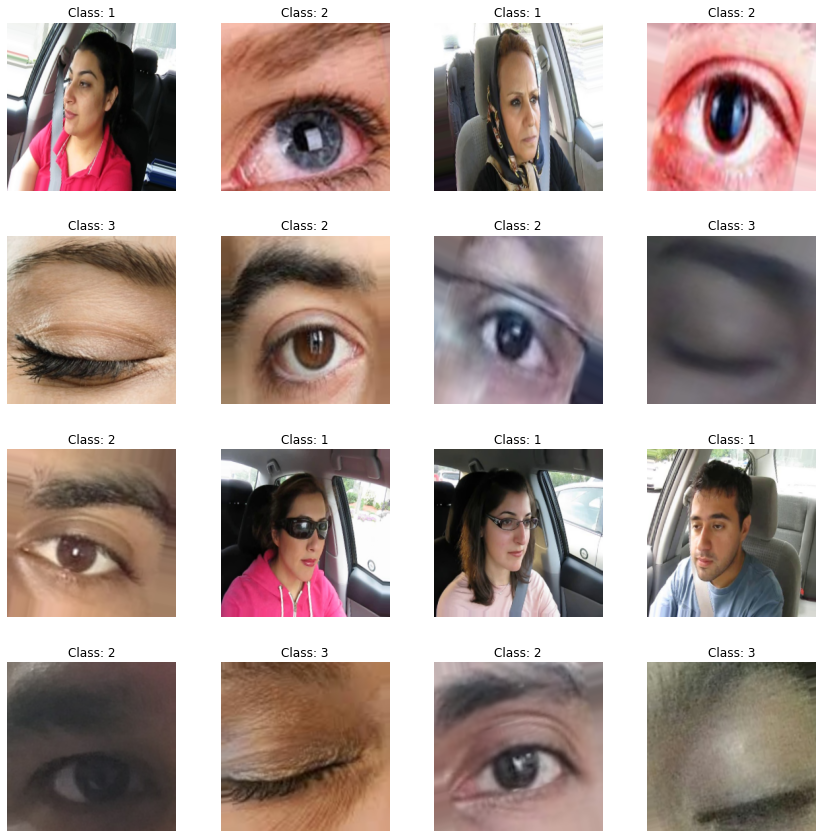

In [14]:
fig, ax = plt.subplots(4, 4, figsize=(12, 12))
fig.tight_layout()

# Number of batches to visualize
num_batches_to_visualize = 3

for batch_idx in range(num_batches_to_visualize):
    # Get a batch of augmented images and labels
    X_batch, y_batch = next(train_gen_flow)
    
    # Plot the images in the current batch
    for i in range(4):
        for j in range(4):
            ax[i, j].imshow(X_batch[i * 4 + j])
            ax[i, j].set_title(f"Class: {y_batch[i * 4 + j]}")
            ax[i, j].axis("off")
    
    plt.show()

In [15]:
from tensorflow.keras import models, layers

In [16]:
with tf.device(device_name):
    inception_model = InceptionV3(weights ='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    """
    We use some layers of Inception net to train our model and we use the weights of imagenet dataset.
    """
    inception_model_1 = Model(inception_model.inputs, inception_model.layers[-1].output)
    for layer in inception_model_1.layers[:230]:
        layer.trainable = False
    

    models = Sequential()
    models.add(inception_model_1)
    models.add(Dense(64, activation="relu"))
    models.add(Flatten())
    models.add(Dropout(0.5))
    models.add(Dense(4, activation="softmax"))

    models.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)



In [17]:
models.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 6, 6, 2048)        21802784  
_________________________________________________________________
dense (Dense)                (None, 6, 6, 64)          131136    
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2304)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 9220      
Total params: 21,943,140
Trainable params: 12,804,804
Non-trainable params: 9,138,336
_________________________________________________________________


In [18]:
history = models.fit(
    train_gen_flow,
    epochs = 10,
    verbose =1,
    shuffle = True,
    validation_data = val_gen_flow
)

Epoch 1/10
127/127 [==============================] - 48s 273ms/step - loss: 0.4073 - accuracy: 0.8660 - val_loss: 1.4198 - val_accuracy: 0.8943
Epoch 2/10
127/127 [==============================] - 29s 228ms/step - loss: 0.1995 - accuracy: 0.9468 - val_loss: 0.3207 - val_accuracy: 0.9287
Epoch 3/10
127/127 [==============================] - 30s 234ms/step - loss: 0.1126 - accuracy: 0.9645 - val_loss: 0.4158 - val_accuracy: 0.9448
Epoch 4/10
127/127 [==============================] - 31s 238ms/step - loss: 0.0868 - accuracy: 0.9749 - val_loss: 0.1475 - val_accuracy: 0.9563
Epoch 5/10
127/127 [==============================] - 27s 211ms/step - loss: 0.0631 - accuracy: 0.9749 - val_loss: 0.1569 - val_accuracy: 0.9724
Epoch 6/10
127/127 [==============================] - 30s 234ms/step - loss: 0.0562 - accuracy: 0.9818 - val_loss: 0.0815 - val_accuracy: 0.9770
Epoch 7/10
127/127 [==============================] - 30s 238ms/step - loss: 0.0636 - accuracy: 0.9837 - val_loss: 0.1279 - val_ac

### We can see that because of the usage of transfer Learning model, on the 10th epoch itself we got an accuracy of 97%. Whereas our proposed model is slightly behind as it reach around 96% after 20 epochs.

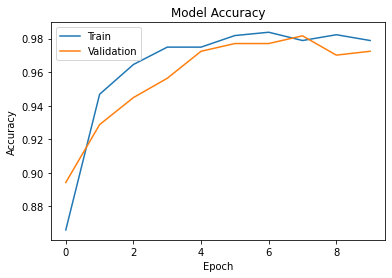

In [19]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

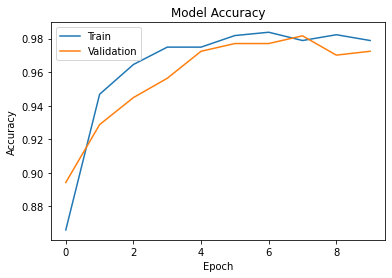

In [20]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

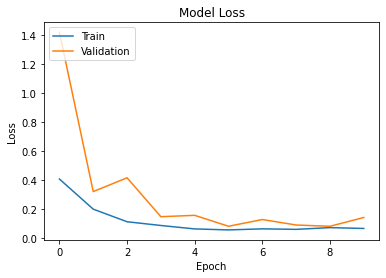

In [21]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [22]:
scores = models.evaluate(test_gen_flow)

28/28 [==============================] - 2s 66ms/step - loss: 0.1470 - accuracy: 0.9724


In [23]:
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Test loss: 0.1469775289297104
Test accuracy: 0.9724137783050537


In [24]:
y_pred = models.predict(X_test)
y_pred_class = np.argmax(y_pred, axis=1)

In [25]:
y_pred_class

array([0, 2, 0, 2, 3, 1, 2, 1, 3, 3, 1, 3, 1, 0, 2, 2, 0, 0, 3, 3, 2, 3,
       2, 3, 3, 0, 1, 1, 0, 3, 2, 1, 0, 2, 0, 3, 0, 1, 2, 0, 0, 3, 2, 2,
       3, 3, 2, 0, 2, 2, 2, 1, 3, 2, 1, 3, 3, 1, 2, 3, 0, 0, 3, 1, 0, 0,
       0, 1, 0, 1, 1, 2, 1, 3, 3, 3, 0, 3, 2, 3, 2, 2, 2, 3, 0, 0, 3, 0,
       0, 1, 2, 1, 0, 3, 3, 1, 1, 3, 3, 1, 1, 2, 3, 3, 2, 3, 1, 0, 1, 3,
       2, 1, 1, 1, 3, 3, 2, 0, 3, 1, 2, 0, 3, 2, 0, 1, 1, 1, 3, 0, 0, 2,
       2, 0, 0, 3, 2, 1, 3, 1, 3, 2, 3, 2, 0, 3, 3, 3, 1, 2, 1, 2, 2, 2,
       2, 1, 3, 2, 0, 3, 1, 2, 0, 1, 0, 1, 3, 0, 1, 1, 2, 1, 3, 1, 0, 3,
       3, 0, 3, 1, 3, 1, 3, 1, 0, 3, 2, 1, 2, 2, 1, 2, 0, 0, 3, 1, 0, 3,
       1, 0, 3, 3, 1, 0, 1, 2, 2, 2, 3, 0, 1, 3, 3, 3, 2, 2, 3, 0, 3, 2,
       2, 3, 1, 3, 1, 3, 2, 1, 1, 0, 0, 3, 0, 3, 3, 1, 3, 3, 0, 1, 3, 3,
       3, 1, 0, 3, 2, 2, 1, 1, 0, 1, 1, 2, 2, 0, 0, 1, 2, 1, 0, 1, 2, 1,
       0, 2, 0, 1, 3, 0, 1, 3, 3, 2, 2, 2, 3, 0, 0, 0, 1, 3, 0, 1, 0, 2,
       3, 2, 2, 0, 3, 2, 0, 2, 0, 2, 0, 1, 0, 1, 1,

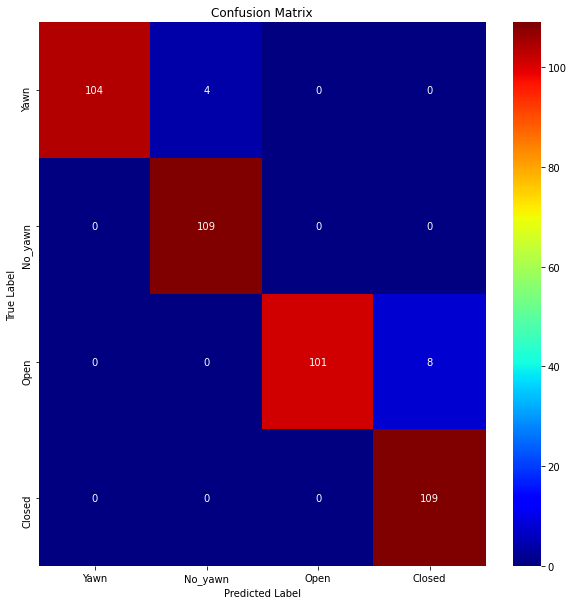

In [26]:
conf_matrix = confusion_matrix(y_test, y_pred_class)

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap="jet", xticklabels=['Yawn', 'No_yawn', 'Open', 'Closed'], yticklabels=['Yawn', 'No_yawn', 'Open', 'Closed'])
plt.title("Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [27]:
# Classification Report
class_report = classification_report(y_test, y_pred_class)
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98       108
           1       0.96      1.00      0.98       109
           2       1.00      0.93      0.96       109
           3       0.93      1.00      0.96       109

    accuracy                           0.97       435
   macro avg       0.97      0.97      0.97       435
weighted avg       0.97      0.97      0.97       435



In [28]:

# Accuracy Precision, Recall, F1-Score
precision = precision_score(y_test, y_pred_class, average='weighted')
recall = recall_score(y_test, y_pred_class, average='weighted')
f1 = f1_score(y_test, y_pred_class, average='weighted')
accuracy = accuracy_score(y_test, y_pred_class)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Accuracy: 0.9724137931034482
Precision: 0.9739967849824426
Recall: 0.9724137931034482
F1-Score: 0.9723850854136838


In [29]:
auc_score = roc_auc_score(y_test, y_pred, multi_class='ovr')
print("AUC:", auc_score)

AUC: 0.9976751530615435


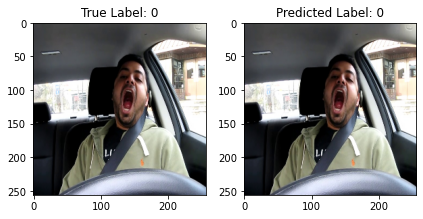

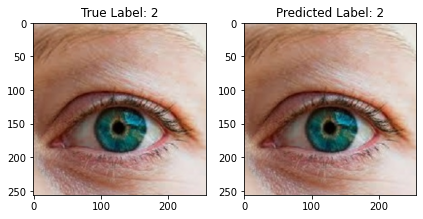

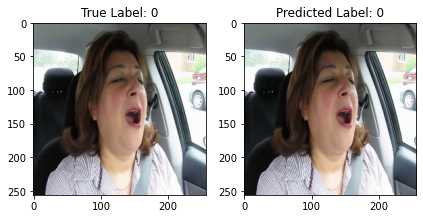

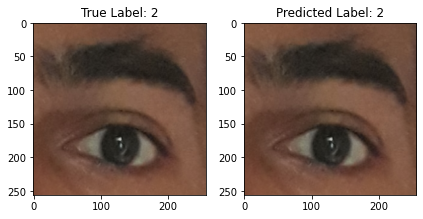

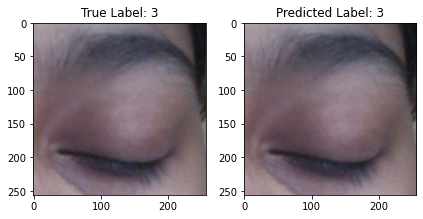

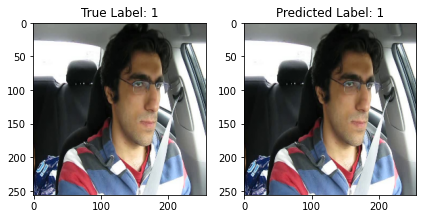

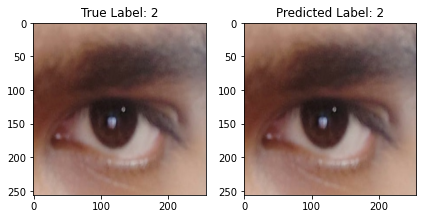

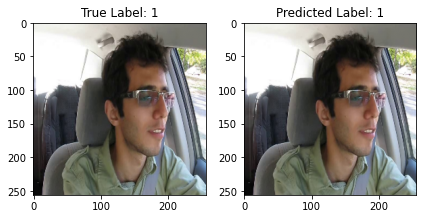

In [30]:
for idx in range(0, 8):
    image = X_test[idx]  # Assuming X_test contains your images
    true_label = y_test[idx]
    predicted_label = y_pred_class[idx]
    
    plt.figure(figsize=(6, 3))
    
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f'True Label: {true_label}')
    
    plt.subplot(1, 2, 2)
    plt.imshow(image)
    plt.title(f'Predicted Label: {predicted_label}')
    
    plt.tight_layout()
    plt.show()


In [31]:
models.save("group_transferlearning.h5")